In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
class SalesForecaster:
    """
    A class for training and forecasting time series data using SARIMAX for multiple stores.
    """

    def __init__(self, data_path):
        self.data_path = data_path

    def load_and_prepare_data(self):
        df = pd.read_excel(self.data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        self.df = df

    def train_test_split(self, store_data, test_size=30):
        train = store_data.iloc[:-test_size]
        test = store_data.iloc[-test_size:]
        return train, test

    def fit_model(self, train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)):
        model = SARIMAX(train['Sales'], 
                        order=order, 
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        return result

    def forecast(self, result, steps):
        pred = result.get_forecast(steps=steps)
        pred_mean = pred.predicted_mean
        pred_ci = pred.conf_int()
        return pred_mean, pred_ci

    def evaluate(self, actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = mean_absolute_percentage_error(actual, predicted)
        return mae, rmse, mape

    def plot_forecast(self, store_name, train, test, pred_mean, pred_ci):
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train['Sales'], label='Train')
        plt.plot(test.index, test['Sales'], label='Test', color='gray')
        plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')
        plt.fill_between(pred_ci.index,
                         pred_ci.iloc[:, 0],
                         pred_ci.iloc[:, 1],
                         color='pink', alpha=0.3)
        plt.title(f"Sales Forecast for {store_name}")
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

    def run_pipeline(self):
        self.load_and_prepare_data()
        for store_name in self.df['Store'].unique():
            print(f"\nProcessing {store_name}...")
            store_data = self.df[self.df['Store'] == store_name]
            store_data = store_data[['Date', 'Sales']].set_index('Date').asfreq('D')
            store_data['Sales'] = store_data['Sales'].interpolate()

            train, test = self.train_test_split(store_data)
            result = self.fit_model(train)
            pred_mean, pred_ci = self.forecast(result, steps=len(test))
            mae, rmse, mape = self.evaluate(test['Sales'], pred_mean)

            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2%}")

            self.plot_forecast(store_name, train, test, pred_mean, pred_ci)


Processing Store A...
MAE: 157.61
RMSE: 203.46
MAPE: 3.48%


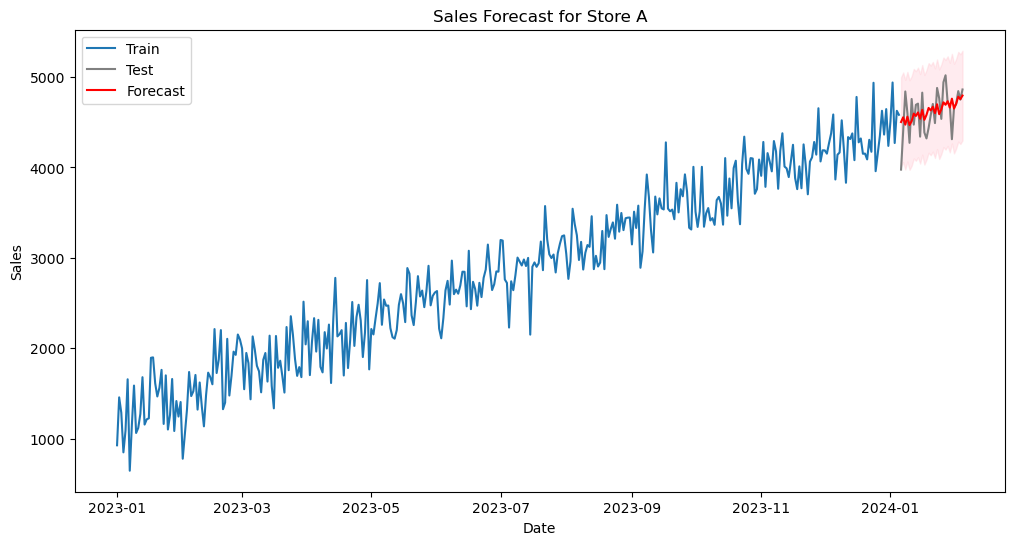


Processing Store B...
MAE: 241.39
RMSE: 309.53
MAPE: 6.40%


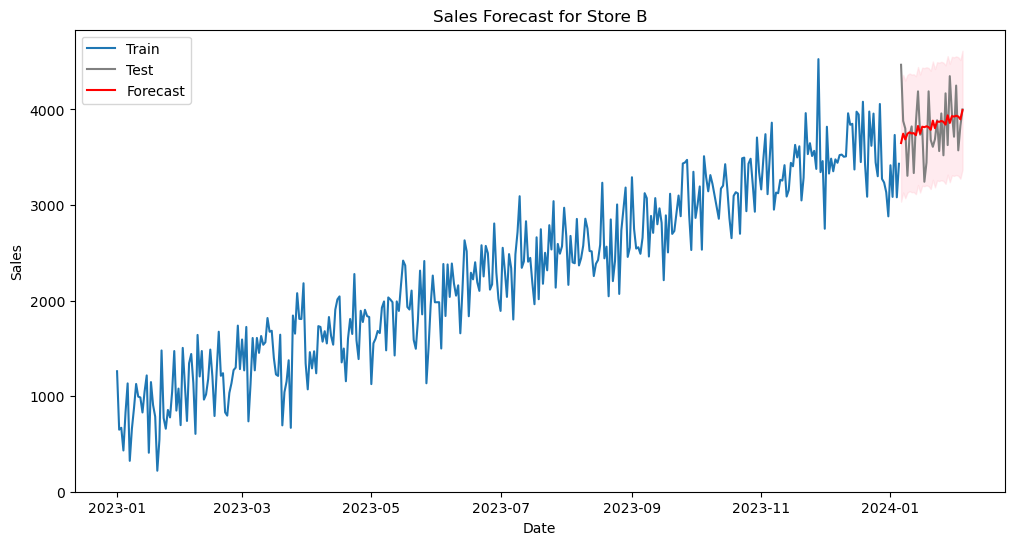

In [7]:
forecaster = SalesForecaster(data_path="fake_sales_data.xlsx")
forecaster.run_pipeline()